In [13]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Description

This notebook assesses the performance improvements provided by using an outlier heuristic

I divided into the following sections:

- 1) Preprocessing
- 2) Algorithm Development
- 3) Results

# 1) Preprocessing
- Reformat data from text file into a numpy array containing distances betweeen points

In [2]:
# Determine dists from every coodinate to all other coordinates
def create_dists(coords):
    return cdist(coords, coords)

In [3]:
# Sort cities based on aggregate distance from all other cities
def find_outliers(dists):
    dist_sum = np.sum(dists, axis=1)
    return np.argsort(dist_sum)[::-1]

# 2) Algorithm Development
- findMinRoute: typical greedy algorithm pulled from geeksforgeeks.org
- greedy_tsp: algorithm I developed utilizing outliers to prioritize ordering (closest point)
- greedier_tsp: algorithm I developed utilizing outliers to prioritize ordering (closest 2 points)

** The below method (findMinRoute()) is pulled from geeksforgeeks.org (https://www.geeksforgeeks.org/travelling-salesman-problem-greedy-approach/) solely to demonstrate how my algorithms perform much better than a standard greedy approach **

In [44]:
# Python3 program from https://www.geeksforgeeks.org/travelling-salesman-problem-greedy-approach/

from typing import DefaultDict


INT_MAX = 2147483647

# Function to find the minimum
# cost path for all the paths
def findMinRoute(tsp):
	sum = 0
	counter = 0
	j = 0
	i = 0
	min = INT_MAX
	visitedRouteList = DefaultDict(int)

	# Starting from the 0th indexed
	# city i.e., the first city
	visitedRouteList[0] = 1
	route = [0] * len(tsp)

	# Traverse the adjacency
	# matrix tsp[][]
	while i < len(tsp) and j < len(tsp[i]):

		# Corner of the Matrix
		if counter >= len(tsp[i]) - 1:
			break

		# If this path is unvisited then
		# and if the cost is less then
		# update the cost
		if j != i and (visitedRouteList[j] == 0):
			if tsp[i][j] < min:
				min = tsp[i][j]
				route[counter] = j + 1

		j += 1

		# Check all paths from the
		# ith indexed city
		if j == len(tsp[i]):
			sum += min
			min = INT_MAX
			visitedRouteList[route[counter] - 1] = 1
			j = 0
			i = route[counter] - 1
			counter += 1

	# Update the ending city in array
	# from city which was last visited
	i = route[counter - 1] - 1

	for j in range(len(tsp)):

		if (i != j) and tsp[i][j] < min:
			min = tsp[i][j]
			route[counter] = j + 1

	sum += min

	return sum

In [5]:
def greedy_tsp(dists, outliers, total_dist = 0., frontier = set(), explored = set(), clusters = []):
    """Connect outermost outliers with nearest city, working inward to end at the most central cities

    Args:
        dists (np.array): 2-d array of distances between every city
        outliers (np.array): ordered list of outlying cities by descending distance
        total_dist (float): total distance travelled throughout route
        frontier (set()): cities connected to one other city, available for another match
        explored (set()): cities connected to two other cities, not available for match
        clusters (list): list of frontier cities for each cluster, avoids sub-route loops
    """
    num_cities = len(dists)
    if not clusters:
        clusters = [x for x in range(num_cities)]
    for i in outliers:
        if i in explored:
            continue
        elif i in frontier:
            explored.add(i)
        else:
            frontier.add(i)

        adj_cities_sorted = np.argsort(dists[i])

        for j in adj_cities_sorted:
            if j in explored or clusters[i] == j or i == j: 
                if num_cities-len(explored) < 2:
                    final_city = frontier-explored
                    k = final_city.pop()
                    total_dist+= dists[j][k]
                    explored.add(k)
                    return total_dist
                continue
            elif j in frontier:
                explored.add(j)
                total_dist += dists[i][j]
                if i in frontier:
                    k = clusters[i]
                    clusters[clusters[i]] = clusters[j] 
                    clusters[clusters[j]] = k
                else:
                    k = clusters[clusters[i]]
                    clusters[clusters[i]] = clusters[j]
                    clusters[clusters[j]] = clusters[i]
                break
            else:
                frontier.add(j)
                total_dist += dists[i][j]
                if i in frontier:
                    k = clusters[i]
                    clusters[clusters[i]] = clusters[j] 
                    clusters[clusters[j]] = k
                else:
                    k = clusters[clusters[i]]
                    clusters[clusters[i]] = clusters[j]
                    clusters[clusters[j]] = clusters[i]
                break

    remaining_cities = frontier-explored
    while len(remaining_cities) > 0:
        c = list(remaining_cities)
        remaining_dists = dists[c][:,c]
        remaining_outliers = []
        for k in outliers:
            if k in c:
                remaining_outliers.append(k)
        total_dist = greedy_tsp(dists, remaining_outliers, total_dist, frontier, explored, clusters)
        return total_dist
    return total_dist  

In [6]:
def greedier_tsp(dists, outliers, total_dist = 0., frontier = set(), explored = set(), clusters = []):
    """Connect outermost outliers with nearest two cities, working inward to end at the most central cities

    Args:
        dists (np.array): 2-d array of distances between every city
        outliers (np.array): ordered list of outlying cities by descending distance
        total_dist (float): total distance travelled throughout route
        frontier (set()): cities connected to one other city, available for another match
        explored (set()): cities connected to two other cities, not available for match
        clusters (list): list of frontier cities for each cluster, avoids sub-route loops
    """
    num_cities = len(dists)
    if not clusters:
        clusters = [x for x in range(num_cities)]
    for i in outliers:
        if i in explored:
            continue
        elif i in frontier:
            explored.add(i)
        else:
            frontier.add(i)
            adj_cities_sorted = np.argsort(dists[i])
            for j in adj_cities_sorted:
                if j in explored or clusters[i] == j:
                    continue
                elif j in frontier:
                    explored.add(j)
                    total_dist += dists[i][j]
    
                    k = clusters[i]
                    clusters[clusters[i]] = clusters[j] 
                    clusters[clusters[j]] = k
                    break
                    
                else:
                    frontier.add(j)
                    total_dist += dists[i][j]
                        
                    k = clusters[i]
                    clusters[clusters[i]] = clusters[j] 
                    clusters[clusters[j]] = k
                    break

        adj_cities_sorted = np.argsort(dists[i])
        for j in adj_cities_sorted:
            explored.add(i)
            if j in explored or clusters[i] == j or i == j: 
                if num_cities-len(explored) < 2:
                    final_city = frontier-explored
                    k = final_city.pop()
                    total_dist+= dists[j][k]
                    explored.add(k)
                    return total_dist
                continue
            elif j in frontier:
                explored.add(j)
                total_dist += dists[i][j]

                k = clusters[clusters[i]]
                clusters[clusters[i]] = clusters[j]
                clusters[clusters[j]] = clusters[i]
                break
                
            else:
                frontier.add(j)
                total_dist += dists[i][j]

                k = clusters[clusters[i]]
                clusters[clusters[i]] = clusters[j]
                clusters[clusters[j]] = clusters[i]
                break

    remaining_cities = frontier-explored
    while len(remaining_cities) > 0:
        c = list(remaining_cities)
        remaining_dists = dists[c][:,c]
        remaining_outliers = []
        for k in outliers:
            if k in c:
                remaining_outliers.append(k)
        total_dist = greedier_tsp(dists, remaining_outliers, total_dist, frontier, explored, clusters)
        return total_dist
    return total_dist  

# 3) Results
- The first few cells import the data and call preprocessing methods
- Following cells will display data for analysis and a visual representation of both algorithm efficiency and route optimality

In [49]:
# Import data from text files into numpy array
djibouti_coords = np.loadtxt('./countries/dj38.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
zimbabwe_coords = np.loadtxt('./countries/zi929.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
rwanda_coords = np.loadtxt('./countries/rw1621.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
oman_coords = np.loadtxt('./countries/mu1979.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
japan_coords = np.loadtxt('./countries/ja9847.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
greece_coords = np.loadtxt('./countries/gr9882.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
finland_coords = np.loadtxt('./countries/fi10639.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
vietnam_coords = np.loadtxt('./countries/vm22775.txt', delimiter = ' ', skiprows=1, usecols=(1,2))
sweden_coords = np.loadtxt('./countries/sw24978.txt', delimiter = ' ', skiprows=1, usecols=(1,2))

In [46]:
# Create placeholders of data for use in follow-on methods
coords = [djibouti_coords, zimbabwe_coords, rwanda_coords, oman_coords, japan_coords, greece_coords, finland_coords, vietnam_coords, sweden_coords]
countries = ['Djibouti', 'Zimbabwe', 'Rwanda', 'Oman', 'Japan', 'Greece', 'Finland', 'Vietnam', 'Sweden']
optimal_dists = [6656, 95345, 26051, 86891, 491924, 300899, 520527, 569288, 855597]

In [47]:
# Create placeholders of data for use in follow-on methods
heuristic_performance = []
non_heuristic_performance = []
heuristic_dists = []
non_heuristic_dists = []

In [48]:
def calculate_route_distance(coord, country, optimal):
    """Calculates minimum route distances using methods defined above, keeps track of algorithm efficiency for analysis

    Args:
        coord (np.array): array containing country coordinates 
        country (string): country being observed
        total_dist (float): optimal route distance
    """
    print(country,"\n")
    dists = create_dists(coord)
    outliers = find_outliers(dists)
    
    print("algorithm efficiency:")
    start_time = time.time()
    total_dist_greedy = greedy_tsp(dists, outliers, total_dist = 0., frontier = set(), explored = set(), clusters = [])
    greedy_time = time.time() - start_time
    print("--- greedy: %s seconds ---" % (greedy_time))
    
    start_time = time.time()
    total_dist_greedier = greedier_tsp(dists, outliers, total_dist = 0., frontier = set(), explored = set(), clusters = [])
    greedier_time = time.time() - start_time
    print("--- greedier: %s seconds ---" % (greedier_time))
    
    start_time = time.time()
    non_heuristic_dist = findMinRoute(dists)
    non_heuristic_time = time.time() - start_time
    print("--- non_heuristic: %s seconds ---" % (non_heuristic_time))

    heuristic_performance.append(greedier_time)
    non_heuristic_performance.append(non_heuristic_time)
    heuristic_dists.append(min(total_dist_greedy, total_dist_greedier))
    non_heuristic_dists.append(non_heuristic_dist)

    print()
    print("total trip distance without heuristic: ", non_heuristic_dist)
    print("total trip distance (greedy tsp): ", total_dist_greedy)
    print("total trip distance (greedier tsp): ", total_dist_greedier)
    route_improvement = 100*(non_heuristic_dist - min(total_dist_greedy, total_dist_greedier))/min(total_dist_greedy, total_dist_greedier)
    print("route improvement using heuristic: ", round(route_improvement, 2), "%")
    print()
    route_to_optimal = 100*min(total_dist_greedy, total_dist_greedier)/optimal-100.0
    print("heuristic-enabled route within", round(route_to_optimal, 2), "% of optimal")
    print("___________________________________________________________")

In [11]:
# Iterate through datasets to evaluate and display algorithm results divided by country
for i in range(len(coords)):
    calculate_route_distance(coords[i], countries[i], optimal_dists[i])

Djibouti 

algorithm efficiency:
--- greedy: 0.00028967857360839844 seconds ---
--- greedier: 0.00017213821411132812 seconds ---
--- non_heuristic: 0.0009012222290039062 seconds ---

total trip distance without heuristic:  8127.343275092695
total trip distance (greedy tsp):  7129.149897030859
total trip distance (greedier tsp):  7720.547719319459
route improvement using heuristic:  14.0 %

heuristic-enabled route within 7.11 % of optimal
___________________________________________________________
Zimbabwe 

algorithm efficiency:
--- greedy: 0.04110121726989746 seconds ---
--- greedier: 0.03674125671386719 seconds ---
--- non_heuristic: 0.34777402877807617 seconds ---

total trip distance without heuristic:  113506.10111820197
total trip distance (greedy tsp):  108575.48222440378
total trip distance (greedier tsp):  112538.10242077727
route improvement using heuristic:  4.54 %

heuristic-enabled route within 13.88 % of optimal
___________________________________________________________


#### Visual representation of algorithm efficiency between geeksforgeeks.org and my heuristic-infused algorithm

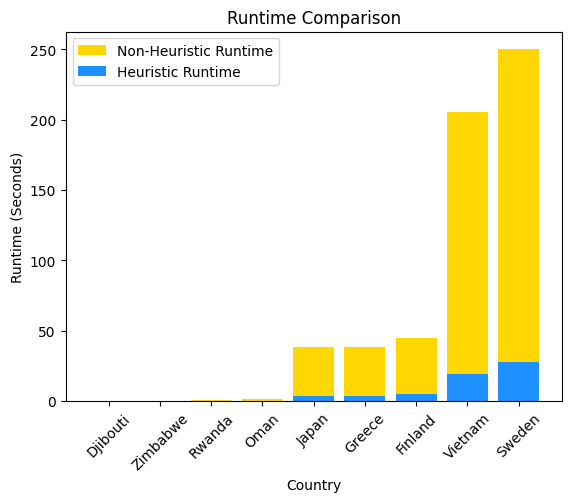

In [43]:
plt.bar(countries, non_heuristic_performance, 
        color='gold', label='Non-Heuristic Runtime')
plt.bar(countries, heuristic_performance, 
        color='dodgerblue', label='Heuristic Runtime')
plt.xticks(countries, rotation=45)
plt.title("Runtime Comparison")
plt.xlabel("Country")
plt.ylabel("Runtime (Seconds)")
plt.legend()
plt.show()

#### Visual representation of algorithm performance between geeksforgeeks.org, my heuristic-infused algorithm, and the optimal route

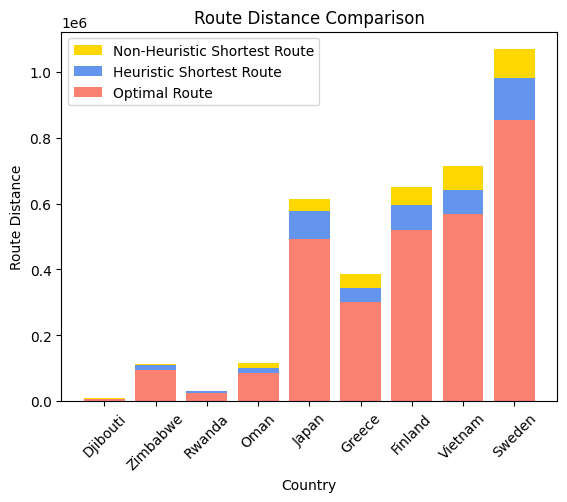

In [42]:
plt.bar(countries, non_heuristic_dists, 
        color='gold', label='Non-Heuristic Shortest Route')
plt.bar(countries, heuristic_dists, 
        color='cornflowerblue', label='Heuristic Shortest Route')
plt.bar(countries, optimal_dists, 
        color='salmon', label='Optimal Route')
plt.xticks(countries, rotation=45)
plt.title("Route Distance Comparison")
plt.xlabel("Country")
plt.ylabel("Route Distance")
plt.legend()
plt.show()